In [1]:
%matplotlib notebook
# calling it a second time may prevent some graphics errors
%matplotlib notebook 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
from model import ResFFN
from data import TwoMoonsDataset
import train
import sklearn.mixture

In [4]:
torch.manual_seed(1997)
np.random.seed(1997)

# Train a model
First we train a FFN with residual connections to ensure smoothness and sensitivity. We use the specifications of [1]: https://arxiv.org/abs/2102.11582

In [5]:
epochs = 150
batch_size = 64
model = ResFFN(2, 2, 128, 4, relu_in_last_hidden=False, leaky_relu_slope=0.01)
if torch.cuda.is_available(): 
    model = model.cuda()

data_train = TwoMoonsDataset(10000, noise=0.1)
data_val = TwoMoonsDataset(200, noise=0.1)
# data_test = TwoMoonsDataset(200, noise=0.1) Unused

loss_history, accuracy_history = train.train_model(model, data_train, data_val, epochs=epochs, batch_size=batch_size)

### Epoch 1 / 150
Validation loss 0.1849; Validation accuracy 0.9300
### Epoch 2 / 150
Validation loss 0.1363; Validation accuracy 0.9600
### Epoch 3 / 150
Validation loss 0.0819; Validation accuracy 0.9650
### Epoch 4 / 150
Validation loss 0.1051; Validation accuracy 0.9650
### Epoch 5 / 150
Validation loss 0.0793; Validation accuracy 0.9750
### Epoch 6 / 150
Validation loss 0.0620; Validation accuracy 0.9800
### Epoch 7 / 150
Validation loss 0.1144; Validation accuracy 0.9700
### Epoch 8 / 150
Validation loss 0.0669; Validation accuracy 0.9850
### Epoch 9 / 150
Validation loss 0.0616; Validation accuracy 0.9800
### Epoch 10 / 150
Validation loss 0.0744; Validation accuracy 0.9850
### Epoch 11 / 150
Validation loss 0.0576; Validation accuracy 0.9900
### Epoch 12 / 150
Validation loss 0.0623; Validation accuracy 0.9800
### Epoch 13 / 150
Validation loss 0.0475; Validation accuracy 0.9850
### Epoch 14 / 150
Validation loss 0.0542; Validation accuracy 0.9950
### Epoch 15 / 150
Validation

Validation loss 0.0434; Validation accuracy 0.9950
### Epoch 119 / 150
Validation loss 0.0288; Validation accuracy 0.9950
### Epoch 120 / 150
Validation loss 0.0350; Validation accuracy 0.9950
### Epoch 121 / 150
Validation loss 0.0335; Validation accuracy 0.9950
### Epoch 122 / 150
Validation loss 0.0372; Validation accuracy 0.9950
### Epoch 123 / 150
Validation loss 0.0377; Validation accuracy 0.9950
### Epoch 124 / 150
Validation loss 0.0341; Validation accuracy 0.9950
### Epoch 125 / 150
Validation loss 0.0358; Validation accuracy 0.9900
### Epoch 126 / 150
Validation loss 0.0303; Validation accuracy 0.9950
### Epoch 127 / 150
Validation loss 0.0389; Validation accuracy 0.9950
### Epoch 128 / 150
Validation loss 0.0316; Validation accuracy 0.9900
### Epoch 129 / 150
Validation loss 0.0353; Validation accuracy 0.9950
### Epoch 130 / 150
Validation loss 0.0542; Validation accuracy 0.9900
### Epoch 131 / 150
Validation loss 0.0404; Validation accuracy 0.9950
### Epoch 132 / 150
Valida

# Fit Gaussian Mixture Model to Feature Space
I found that estimating the covariance matrix per class from the feature representations directly leads to singular matrices. Investigating this issue I tried several things to circumcome this issue:
- Use a Leaky ReLU to prevent fixed "0"s in feature represenations, leading to zero variance components in the feature space which causes singularity
- Don't apply any non-linearity when extracting features to induce more variance

Finally, instead of estimating the mean and covariance directly from feature represenations per class I instead fitted a 1-component GMM to estimate a Gaussian distribution per class in the feature space.

In [6]:
zs, ys = [], []
model.eval()
data_loader_train = torch.utils.data.DataLoader(data_train, batch_size=128, drop_last=False)
with torch.no_grad():
    for (x, y) in tqdm(data_loader_train):
        x = x.float()
        if torch.cuda.is_available():
            x = x.cuda()
        zs.append(model(x, return_features=True))
        ys.append(y)
z = torch.cat(zs).detach().cpu().numpy()
y = torch.cat(ys).detach().cpu().numpy()

100%|██████████| 79/79 [00:00<00:00, 113.08it/s]


In [7]:
components, mixture_coefs = {}, {}
for label in np.unique(y):
    components[label] = sklearn.mixture.GaussianMixture(n_components=1, covariance_type='full')
    components[label].fit(z[y == label])
    mixture_coefs[label] = (y == label).sum() / y.shape[0]

In [8]:
# This cell checks if a multivariate normal can be "fitted regularly" using numpys cov and mean methods
"""
mean = np.mean(z[y == 0], axis=0)
cov = np.cov(z[y == 0], rowvar=False)
import scipy.stats
scipy.stats.multivariate_normal.pdf(np.random.randn(5, 128), mean, cov)
"""
pass

In [9]:
# Create a mesh and get feature representations of all points within the mesh
X, Y = np.meshgrid(np.linspace(-3., 3., 1000), np.linspace(-3., 3., 1000))
XX = np.array([X.ravel(), Y.ravel()]).T
data_mesh = torch.utils.data.TensorDataset(torch.Tensor(XX))
data_loader_mesh = torch.utils.data.DataLoader(data_mesh, batch_size=2048, drop_last=False)

In [10]:
zs_mesh = []
with torch.no_grad():
    for (x,) in tqdm(data_loader_mesh):
        x = x.float()
        if torch.cuda.is_available():
            x = x.cuda()
        zs_mesh.append(model(x, return_features=True))
z_mesh = torch.cat(zs_mesh).detach().cpu().numpy()

100%|██████████| 489/489 [00:14<00:00, 33.56it/s]


In [11]:
scores = np.zeros(z_mesh.shape[0])
for label in components:
    scores += mixture_coefs[label] * components[label].score_samples(z_mesh)
scores = scores.reshape(X.shape)

<IPython.core.display.Javascript object>


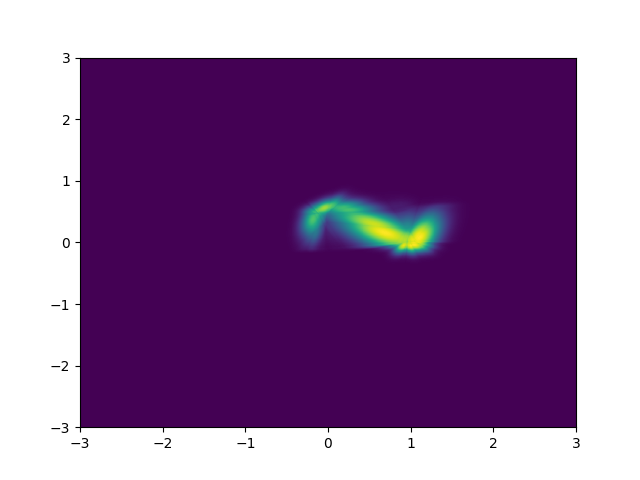

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


In [12]:
plt.pcolormesh(X, Y, np.exp(1e-2 * scores))

In [14]:
plt.savefig('TwoMoons.png')